In [1]:
using ChangesOfVariables, InverseFunctions, ArraysOfArrays, Statistics
using Optimisers
using PyPlot
using LaTeXStrings
using Distributions
using Test
using ForwardDiff
using LinearAlgebra

using Revise
using EuclidianNormalizingFlows

In [3]:
```
Compare transformation results & gradients using ForwardDiff and custom pullbacks.
```
function run_test_suite(; nrepetitions = 5,
        ndims = 5,
        nparams = 3,
        nsmpls = 50,
        dist = Uniform(-3, 3),
    )
    
    for i in 1:nrepetitions
        
        w = rand(dist, ndims, nparams)
        h = rand(dist, ndims, nparams)
        d = rand(dist, ndims, nparams-1)
        x = rand(Normal(0, 6), ndims, nsmpls)
        
        try 
            
            trafo_frwd = RationalQuadSpline(w,h,d)
            trafo_bcwd = RationalQuadSplineInv(w,h,d)

            x_fwd, jac_frwd = EuclidianNormalizingFlows.with_logabsdet_jacobian(trafo_frwd, x)
            x_bcwd, jac_bcwd = EuclidianNormalizingFlows.with_logabsdet_jacobian(trafo_bcwd, x_fwd) 

            @test x_bcwd ≈ x
            @test jac_frwd ≈ -jac_bcwd

            neg_ll, gradvals = EuclidianNormalizingFlows.mvnormal_negll_trafograd(trafo_frwd, x)

            a_run = ForwardDiff.gradient(par -> EuclidianNormalizingFlows.mvnormal_negll_trafo(RationalQuadSpline(par,h,d), x), w)
            @test a_run ≈ gradvals.widths

            a_run = ForwardDiff.gradient(par -> EuclidianNormalizingFlows.mvnormal_negll_trafo(RationalQuadSpline(w,par,d), x), h)
            @test a_run ≈ gradvals.heights

            a_run = ForwardDiff.gradient(par -> EuclidianNormalizingFlows.mvnormal_negll_trafo(RationalQuadSpline(w,h,par), x), d)
            @test a_run ≈ gradvals.derivatives
            
            for j in 1:size(x, 2)
                xrun = x[:,j]
                autodiff_jac = ForwardDiff.jacobian(xtmp -> trafo_frwd(reshape(xtmp, ndims,1)), xrun )
                @test log(det(abs.(autodiff_jac))) ≈ jac_frwd[1,j] ≈ -jac_bcwd[1, j]
            end

        catch 
            print("Test error. Parameters: \n")
            @show w, h, d, x
        end
        
    end
end

run_test_suite()

# Simple fit: 

In [4]:
nparams = 15
nsmpls = 3000
ndims = 2
K = nparams

dist = Uniform(-1, 1)

trafo_truth = RationalQuadSplineInv(rand(dist, ndims, nparams),rand(dist, ndims, nparams),rand(dist, ndims, nparams-1))

y = rand(Normal(0, 1), ndims, nsmpls)
x = trafo_truth(y);

In [5]:
@test x ≈ RationalQuadSpline(trafo_truth.widths,trafo_truth.heights,trafo_truth.derivatives)(RationalQuadSplineInv(trafo_truth.widths,trafo_truth.heights,trafo_truth.derivatives)(x))

Test Passed
  Expression: x ≈ (RationalQuadSpline(trafo_truth.widths, trafo_truth.heights, trafo_truth.derivatives))((RationalQuadSplineInv(trafo_truth.widths, trafo_truth.heights, trafo_truth.derivatives))(x))
   Evaluated: [-2.330332256636272 0.15200291749981937 … -0.39922987037469637 0.1859878057116689; -2.862823374270776 -1.6269483027952725 … -0.6808657489066929 -1.5258114193255745] ≈ [-2.330332256636272 0.1520029174998193 … -0.39922987037469637 0.1859878057116689; -2.8628233742707754 -1.626948302795272 … -0.6808657489066928 -1.5258114193255745]

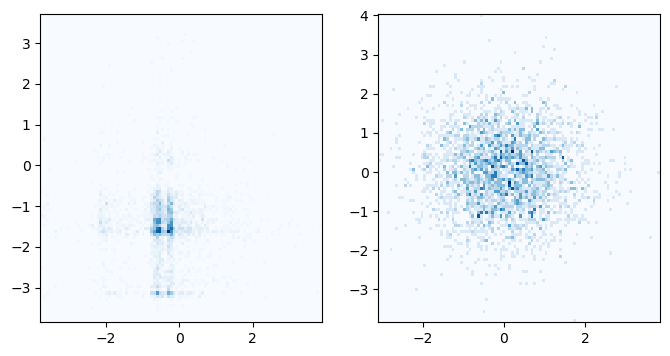

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [-3.083521056875873, -3.014290169839964, -2.945059282804055, -2.8758283957681456, -2.806597508732237, -2.7373666216963275, -2.6681357346604186, -2.5989048476245094, -2.5296739605886005, -2.460443073552691  …  3.2164896633918554, 3.2857205504277642, 3.354951437463673, 3.424182324499582, 3.4934132115354917, 3.5626440985714005, 3.6318749856073094, 3.701105872643219, 3.770336759679128, 3.8395676467150373], [-3.8380892292591, -3.759397833881913, -3.680706438504727, -3.6020150431275404, -3.523323647750354, -3.444632252373167, -3.365940856995981, -3.2872494616187944, -3.2085580662416078, -3.1298666708644216  …  3.322827750064869, 3.401519145442056, 3.4802105408192423, 3.5589019361964285, 3.6375933315736155, 3.7162847269508017, 3.794976122327988, 3.873667517705175, 3.952358913082361, 4.031050308459548], PyObject <matplotlib.collections.QuadMesh object at 0x7fe4ed6503a0>)

In [6]:
fig, ax = plt.subplots(1,2,  figsize=(8,4))

ax[1].hist2d(x[1,:], x[2,:], 100, cmap="Blues")
# ax[1].scatter(x[1,:], x[2,:], s=0.1, alpha=0.2, color="C0")

ax[2].hist2d(y[1,:], y[2,:], 100, cmap="Blues")
# ax[2].scatter(y[1,:], y[2,:], s=0.1, alpha=0.5, color="C0")

In [7]:
# initial_trafo = 
#     EuclidianNormalizingFlows.JohnsonTrafo([10.0, 11.0], [3.5, 3.6], [10.0, 11.0], [1.0, 1.1]) ∘
#     EuclidianNormalizingFlows.ScaleShiftTrafo(ones(ndims), zeros(ndims)) ∘  
#     RationalQuadSpline(ones(ndims, nparams), ones(ndims, nparams), ones(ndims, nparams-1))

# initial_trafo =  ScaleShiftTrafo(ones(ndims), zeros(ndims))

initial_trafo =  RationalQuadSpline(ones(ndims, nparams), ones(ndims, nparams), ones(ndims, nparams-1))

optimizer = ADAGrad()
smpls = nestedview(x)
nbatches = 20
nepochs = 10 

r = EuclidianNormalizingFlows.optimize_whitening(smpls, initial_trafo, optimizer, nbatches = nbatches, nepochs = nepochs)

(result = RationalQuadSpline([0.9647856753527861 0.9634851088311169 … 1.0970113517530882 1.1019501219051524; 0.8395322085143383 0.8395322085143383 … 1.048200079128629 1.0526573535618873], [1.171955051269726 1.1810457957222675 … 0.9694325034214949 0.9472370720476238; 1.1548960485712148 1.1548960485712148 … 0.739941505484829 0.7313428599620102], [0.400701530101124 2.6228293185457012 … -0.3027987108316001 0.37780595754042534; 1.0 0.836878247289754 … 0.1689596681537894 0.5236611564868953]), optimizer_state = (widths = Leaf(AdaGrad{Float32}(0.1, 1.19209f-7), [19.4379 19.4073 … 17.2236 17.3862; 6.15809 6.15809 … 2.10024 2.11357]), heights = Leaf(AdaGrad{Float32}(0.1, 1.19209f-7), [0.35442 0.360112 … 0.255329 0.250461; 1.08038 1.08038 … 0.340268 0.338961]), derivatives = Leaf(AdaGrad{Float32}(0.1, 1.19209f-7), [2.14762e-6 0.00116747 … 4.89634e-5 8.94491e-6; 1.19209e-7 0.000227727 … 6.04946e-5 9.72704e-6])), negll_history = [4.0826931288185, 2.7063572800367757, 2.6781993775642188, 2.4361737949

In [8]:
yhat = r.result(x)

2×3000 Matrix{Float64}:
 -2.26834   1.01996    1.53447   …  -0.674355  0.0237664   1.05086
 -1.2715   -0.408022  -0.733321      1.18759   1.25417    -0.141815

In [9]:
@show mean(yhat, dims=2)
@show std(yhat, dims=2)

mean(yhat, dims = 2) = [-0.0037068404117230067; -0.0015044800869623768;;]
std(yhat, dims = 2) = [1.0335269548790016; 0.9953829790638138;;]


2×1 Matrix{Float64}:
 1.0335269548790016
 0.9953829790638138

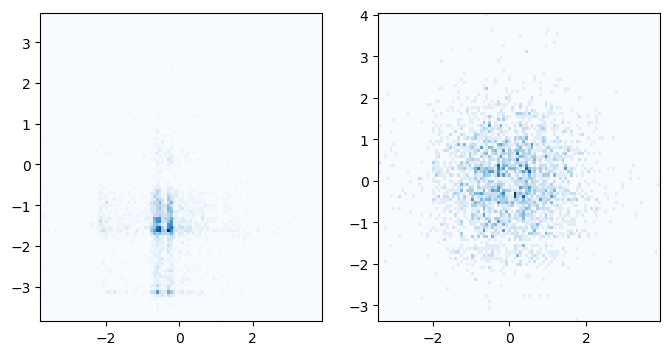

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [-3.4186438573489237, -3.3450789747186724, -3.2715140920884207, -3.1979492094581694, -3.1243843268279177, -3.0508194441976664, -2.9772545615674146, -2.9036896789371633, -2.8301247963069116, -2.7565599136766603  …  3.2757604620039613, 3.349325344634213, 3.422890227264465, 3.4964551098947165, 3.5700199925249674, 3.643584875155219, 3.717149757785471, 3.7907146404157217, 3.8642795230459734, 3.9378444056762247], [-3.3888371077105415, -3.3146530039077318, -3.240468900104922, -3.1662847963021123, -3.0921006924993026, -3.017916588696493, -2.943732484893683, -2.8695483810908735, -2.795364277288064, -2.721180173485254  …  3.3619163383451394, 3.436100442147949, 3.510284545950759, 3.5844686497535685, 3.658652753556378, 3.732836857359188, 3.8070209611619976, 3.8812050649648073, 3.955389168767617, 4.029573272570427], PyObject <matplotlib.collections.QuadMesh object at 0x7fe4ece3ef40>)

In [10]:
fig, ax = plt.subplots(1,2,  figsize=(8,4))

ax[1].hist2d(x[1,:], x[2,:], 100, cmap="Blues")
# ax[1].scatter(x[1,:], x[2,:], s=0.1, alpha=0.2, color="C0")

ax[2].hist2d(yhat[1,:], yhat[2,:], 100, cmap="Blues")
# ax[2].scatter(y[1,:], y[2,:], s=0.1, alpha=0.5, color="C0")

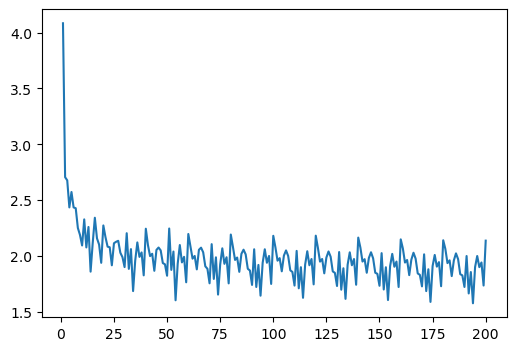

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe4ed822c70>

In [11]:
fig, ax = plt.subplots(1,1,  figsize=(6,4))

ax.plot(1:length(r.negll_history), r.negll_history)

# More complex fit: 

In [12]:
nparams = 20
nsmpls = 2000
ndims = 20
K = nparams
dist = Uniform(-1, 1)

y = rand(Normal(0, 1), ndims, nsmpls)

20×2000 Matrix{Float64}:
  1.23949      1.11945      0.729873  …  -0.350559   1.19711    -0.517714
  0.544676    -0.418521    -0.253968     -0.295449  -2.15424    -0.538492
  0.655679    -0.274956    -0.80198      -0.884413  -0.330194    1.08421
 -0.435802     2.99558      1.61356       0.536054  -0.575593    0.399517
 -1.22324      0.683026     1.61107       1.10867    1.64512     0.0128886
 -1.18436     -0.591256    -0.860663  …   1.36568   -1.8904      0.775138
 -0.00662245   0.329787     0.743558     -0.748169   0.526976   -1.40874
 -1.14635     -1.02535     -0.530752      1.16569    1.28295     0.526867
  1.67181     -0.0330201    0.685027     -0.367921  -1.26988     0.25193
 -2.0449       0.642551     1.19054       0.534105  -1.42031     0.972392
  0.54271     -2.14426     -0.130084  …   0.987556   0.0182473  -1.19568
  1.41806     -0.00955465  -0.605432      0.848815  -0.309183   -2.05148
 -0.244634    -0.64634      0.842831     -0.145311  -0.251598   -0.647045
 -0.793664    -0.

In [13]:
bwd_true =
#     EuclidianNormalizingFlows.ScaleShiftTrafo([1., 0.4], [2.5, -1.2]) ∘
#     EuclidianNormalizingFlows.HouseholderTrafo([1.0, 0.3]) ∘
#     EuclidianNormalizingFlows.CenterStretch([1.0, 0.1], [2.0, 2.1], [1.0, 1.1]) ∘
    RationalQuadSplineInv(rand(dist, ndims, nparams),rand(dist, ndims, nparams),rand(dist, ndims, nparams-1))

x = bwd_true(y)

20×2000 Matrix{Float64}:
  0.794829    0.687453    0.243848   …  -0.711067    0.756093  -0.806243
  0.228528   -0.0854218  -0.0202701     -0.0336802  -2.0244    -0.264432
  0.99517     0.313634   -0.139266      -0.210738    0.286325   1.86794
  0.842164    2.89276     1.81448        0.982707    0.613089   0.951517
 -1.36904    -0.131489    1.64209        0.879617    1.79911   -0.930256
 -0.122791   -0.0539793  -0.0807681  …   1.03221    -1.49097    0.590948
 -0.9841     -0.460316    0.0894207     -1.93053    -0.175701  -2.24656
 -0.845146   -0.830667   -0.608775       1.82921     1.90639    1.15407
  1.08704    -0.55713     0.346052      -1.01058    -1.8431    -0.160085
 -1.35925     0.702622    1.6694         0.644605   -0.369689   1.36952
  0.96535    -2.27309     0.29279    …   1.36022     0.432882  -0.749927
  2.92508     0.830405    0.523321       1.54702     0.57954    0.148693
  0.605756    0.53111     2.81791        0.629009    0.604328   0.530958
 -0.362807    0.0971017   0.80

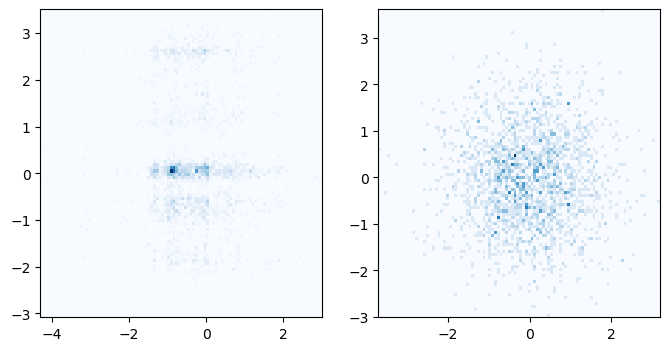

In [14]:
fig, ax = plt.subplots(1,2,  figsize=(8,4))

ax[1].hist2d(x[1,:], x[2,:], 100, cmap="Blues")
# ax[1].scatter(x[1,:], x[2,:], s=0.1, alpha=0.2, color="C0")

ax[2].hist2d(y[1,:], y[2,:], 100, cmap="Blues");
# ax[2].scatter(y[1,:], y[2,:], s=0.1, alpha=0.5, color="C0")

In [15]:
initial_trafo = 
    RationalQuadSpline(ones(ndims, 40), ones(ndims, 40), ones(ndims, 40-1)) #∘
#     EuclidianNormalizingFlows.ScaleShiftTrafo([1., 1], [2., 2]) 

optimizer = ADAGrad(0.1)
smpls = nestedview(x)
nbatches = 50
nepochs = 20 

r = EuclidianNormalizingFlows.optimize_whitening(smpls, initial_trafo, optimizer, nbatches = nbatches, nepochs = nepochs);

In [21]:
yhat = r.result(x);

In [20]:
@show mean(yhat, dims=2)
@show std(yhat, dims=2);

mean(yhat, dims = 2) = [-0.011309466506254126; 0.0008065668936185919; 0.03934907742218347; 0.0018046801580318228; 0.050523308198301885; 0.053522022599361535; 0.039169020139087435; -0.01660810877843139; 0.023362442339702905; -0.024529262554247238; 0.011212155175524525; -0.04525047865733471; 0.01799332976532645; 0.029221592888081065; 0.01365798386188437; 0.04798474732788735; 0.009813807827628312; 0.0259930170811979; -0.020253955156475118; 0.012006816511422018;;]
std(yhat, dims = 2) = [1.009519733645951; 0.9942305703950479; 1.0134648538260964; 1.0041047405515577; 0.9938309305735994; 0.9957593488975384; 0.998168909483923; 0.9867177649006117; 0.9990008234688715; 1.0114777403059065; 1.0063069350489113; 1.0168955599073533; 0.993906402330135; 0.994714992234644; 1.0129653987948177; 0.9931683821041157; 0.9980012512553694; 1.0086653109908896; 1.0148399762748028; 0.9858436347224809;;]


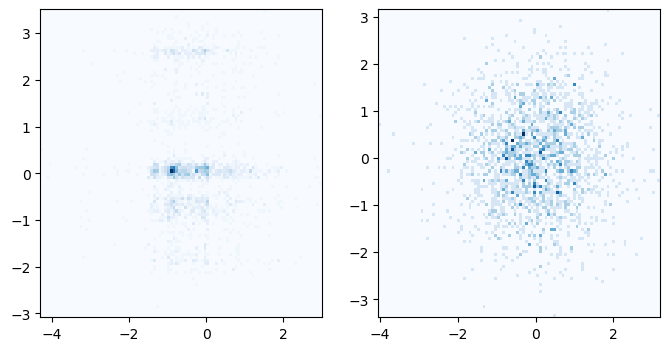

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [-4.035963905207049, -3.9635849583650145, -3.8912060115229803, -3.8188270646809457, -3.7464481178389115, -3.6740691709968774, -3.601690224154843, -3.529311277312809, -3.456932330470775, -3.3845533836287407  …  2.550520257418067, 2.6228992042601007, 2.6952781511021353, 2.767657097944169, 2.8400360447862036, 2.9124149916282382, 2.984793938470272, 3.0571728853123066, 3.1295518321543403, 3.2019307789963745], [-3.3795974876431427, -3.3142589627741343, -3.248920437905126, -3.1835819130361176, -3.118243388167109, -3.0529048632981004, -2.987566338429092, -2.9222278135600837, -2.8568892886910753, -2.791550763822067  …  2.566208275436623, 2.6315468003056313, 2.6968853251746396, 2.762223850043648, 2.8275623749126564, 2.8929008997816648, 2.958239424650674, 3.0235779495196824, 3.0889164743886908, 3.1542549992576987], PyObject <matplotlib.collections.QuadMesh object at 0x7fe4ee7f0520>)

In [18]:
fig, ax = plt.subplots(1,2,  figsize=(8,4))

ax[1].hist2d(x[1,:], x[2,:], 100, cmap="Blues")
# ax[1].scatter(x[1,:], x[2,:], s=0.1, alpha=0.2, color="C0")

ax[2].hist2d(yhat[1,:], yhat[2,:], 100, cmap="Blues")
# ax[2].scatter(y[1,:], y[2,:], s=0.1, alpha=0.5, color="C0")

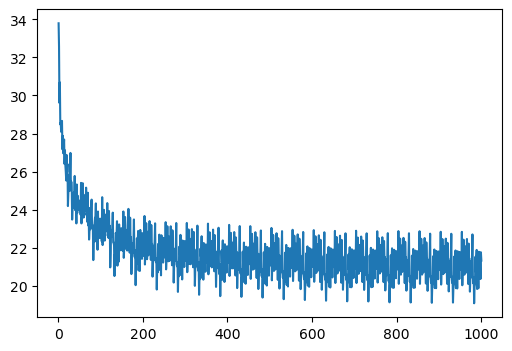

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe4eeb1d070>

In [19]:
fig, ax = plt.subplots(1,1,  figsize=(6,4))

ax.plot(1:length(r.negll_history), r.negll_history)